In [1]:
#%matplotlib inline
import sys
import os


import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import pandas as pd
import networkx as nx
import scipy.stats as stt
#optional for nicer plots
import seaborn
clrs = seaborn.color_palette(n_colors=6)
seaborn.set(style='ticks',font_scale=1.5)

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
poke_pos = np.array([1,-1])*np.array([ [149,0],
                                 [68,19],[231,19],
                               [0,62],[149,62],[298,62],
                                 [68,105],[231,105],
                                      [149,124]])

In [3]:
sys.path.append("/Users/yves/Desktop/retreat_data_dir/code/")
from mecll.task import plot_activity_on_graph

In [4]:
def load_data(selected_session,by_dir=False):
    
    """ Function to load data structured according to the format
        that the data were delivered to the retreat for
    """
    all_data_dir = '/Users/yves/Desktop/retreat_data_dir/data/'
    all_data_folders = sorted([i for i in os.listdir(all_data_dir) if 'ks25' in i])
    root_dir = os.path.join(all_data_dir,all_data_folders[selected_session])
    spkT = np.load(os.path.join(root_dir,'spkT_task.npy'))


    #This array is the same shape as spkT but shows which cluster each of the spikes in spkT belongs to
    spkC = np.load(os.path.join(root_dir,'spkC_task.npy'))

    #This is basically a big table (you can open it in excel) which contains
    #relevant information about each time the animal poked one of the ports
    task_event_df = pd.read_csv(os.path.join(root_dir,'task_event_table.csv'),index_col=0)

    #
    response_table = np.load(os.path.join(root_dir,'neuron_response_table.npy'))
    #alternatively to change the time window


    #not all cluster in spkC correspond to single units. Single units is an array of the clusters that are single units
    single_units = np.load(os.path.join(root_dir,'single_units.npy'))
    
    
    seq0 = np.array(eval(task_event_df.loc[task_event_df['task_nr']==0]['current_sequence'].values[0]))
    seq1 = np.array(eval(task_event_df.loc[task_event_df['task_nr']==1]['current_sequence'].values[0]))
    
    
    graph_type0 = task_event_df.loc[task_event_df['task_nr']==0]['graph_type'].values[0]
    graph_type1 = task_event_df.loc[task_event_df['task_nr']==0]['graph_type'].values[0]
    
    if by_dir:
        firing_rate_maps = get_task_responses_by_direction(task_event_df,response_table)
    else:
        firing_rate_maps = get_task_responses(task_event_df,response_table)
    
    return firing_rate_maps, task_event_df,seq0,seq1,graph_type0,graph_type1

In [5]:
def get_task_responses_by_direction(task_event_df,response_table):
    """ 
    Use the columns of the task_event_df to filter neural activity. 
    In this example build separate firing rate maps for each of the
    tasks, selecting only trials where subjects poked the correct poke.
    
    
    """
    
    
    n_neurons = response_table.shape[1]
    n_ports = 9
    n_tasks = 2
    n_direction = 2
    
    #set variables to nan to not confuse missing data for no responses
    firing_rate_maps = np.zeros([n_neurons,n_ports,n_tasks,n_direction]) + np.nan
    
    #for each task
    for task in [0,1]:
        
        for port in range(n_ports):  #for each port
            
            for dix,direction in enumerate(np.unique(task_event_df['direction'].values)):

                #Select indices of pokes where...
                table_index = task_event_df.loc[(task_event_df['task_nr']==task) &  #task_nr was task
                                                (task_event_df['correct']==True) &  #the poke was to the correct port
                                                (task_event_df['port']==port) &       #the port poked was port
                                                (task_event_df['direction']==direction)
                                               ].index           
                #print(len(table_index))
                #get the average
                firing_rate_maps[:,int(port),int(task),dix] = np.nanmean(response_table[table_index],axis=0)
    return firing_rate_maps
                                         

In [6]:
def get_task_responses(task_event_df,response_table):
    """ 
    Use the columns of the task_event_df to filter neural activity. 
    In this example build separate firing rate maps for each of the
    tasks, selecting only trials where subjects poked the correct poke.
    
    
    """
    
    
    n_neurons = response_table.shape[1]
    n_ports = 9
    n_tasks = 2
    n_direction = 2
    
    #set variables to nan to not confuse missing data for no responses
    firing_rate_maps = np.zeros([n_neurons,n_ports,n_tasks]) + np.nan
    
    #for each task
    for task in [0,1]:
        
        for port in range(n_ports):  #for each port
            
            #for dix,direction in enumerate(np.unique(task_event_df['direction'].values)):

                #Select indices of pokes where...
            table_index = task_event_df.loc[(task_event_df['task_nr']==task) &  #task_nr was task
                                            (task_event_df['correct']==True) &  #the poke was to the correct port
                                            (task_event_df['port']==port)        #the port poked was port
                                            #(task_event_df['direction']==direction)
                                           ].index           
            #print(len(table_index))
            #get the average
            firing_rate_maps[:,int(port),int(task)] = np.nanmean(response_table[table_index],axis=0)
    return firing_rate_maps

In [7]:
from scipy.spatial.distance import pdist
from scipy.spatial import distance_matrix

def zscore(dat): return (dat-np.mean(dat))/np.std(dat)

In [8]:
def loop_distance_matrix(seq,p=2):
    seq = list(seq)
    d = np.zeros([9,9])
    for i in range(9):
        for j in range(9):
            ind1 = seq.index(i)
            ind2 = seq.index(j)
            d[i,j] = min([abs(ind1-ind2),abs(9+(ind1-ind2)),abs(9+(ind2-ind1))])**p
    return d

In [9]:
def line_distance_matrix(seq,p=1):
    seq = list(seq)
    d = np.zeros([9,9])
    for i in range(9):
        for j in range(9):
            ind1 = seq.index(i)
            ind2 = seq.index(j)
            d[i,j] = abs(ind1-ind2)**p
    return d

In [10]:
def remove_diagonal(A):
    removed = A[~np.eye(A.shape[0], dtype=bool)].reshape(A.shape[0], int(A.shape[0])-1, -1)
    return np.squeeze(removed)


# RSA Task distance with direction

In [64]:
def get_spatial_tuning(poke_pos,peak_loc,width):
    """"""
    #for i in range(9):
    distance_matrix = np.abs((poke_pos[peak_loc]-poke_pos)**2).sum(axis=1)
    fr = norm(scale=width).pdf(distance_matrix)
    return fr#distance_matrix
        
def get_task_tuning_line(seq,peak_loc,width):
    task_dists = np.abs(peak_loc-np.arange(9))
#     fr = norm(scale=width).pdf(task_dists)
    fr = np.sin(task_dists)
    return fr[seq]#task_dists[seq]#[task_dists[i] for i in seq]#fr#[fr[i] for i in seq]

In [12]:
seq01 = [list(seq0).index(i) for i in range(9)]

NameError: name 'seq0' is not defined

In [13]:
seq0

NameError: name 'seq0' is not defined

In [14]:
[np.arange(9)[i] for i in seq0]

NameError: name 'seq0' is not defined

In [15]:
n_neurons = 100

seq0 = np.random.permutation(np.arange(9))
seq1 = np.random.permutation(np.arange(9))
seq01 = [list(seq0).index(i) for i in range(9)]
graph_type0 = 'line'
graph_type1 = 'loop'

In [54]:
from scipy.stats import norm


act_matrix = []
for nix in range(n_neurons):
    peak_space = np.random.randint(0,9)
    std_space = np.random.randint(1000,12000)
    
    lamda1 = get_spatial_tuning(poke_pos,peak_space,std_space)
    lamda1 = lamda1/np.max(lamda1)
    
    peak_t1 = np.random.randint(0,9)
    std_t1 = np.random.randint(3,6)
    lamda2 = 1*get_task_tuning_line(seq01,peak_t1,std_t1)
    lamda2 = lamda2/np.max(lamda2)
    
    
    #peak_t2= np.random.randint(0,9)
    #std_t2 = np.random.randint(1,40)/10.
    w1 = np.random.normal()
    w2 = np.random.normal()
    activity = lamda1 + lamda2 + np.random.normal(scale=.1,size=9)
    act_matrix.append(activity.copy())
act_matrix = np.array(act_matrix).T

In [55]:
spatial_distance = -distance_matrix(poke_pos,poke_pos,p=2)
if graph_type0=='loop': 
    task_1_distance = -loop_distance_matrix(seq0,p=1)
else: 
    task_1_distance =  -line_distance_matrix(seq0,p=2)#-(distance_matrix(seq0.reshape(-1,1),seq0.reshape(-1,1),p=1))
if graph_type1=='loop':
    task_2_distance = -loop_distance_matrix(seq1,p=2)
else:
    task_2_distance = -line_distance_matrix(seq1,p=2)

In [56]:
#np.argsort(lamda2)[::-1]
#seq0

In [57]:
act_matrix[:,0]

array([ 0.85200494, -0.84731056,  0.07774138,  0.82390959,  0.8979278 ,
        0.07243107, -1.25316415,  1.1332115 ,  1.00842109])

In [58]:
np.argmax(act_matrix[:,0])

7

In [59]:
act_matrix = np.array(act_matrix)

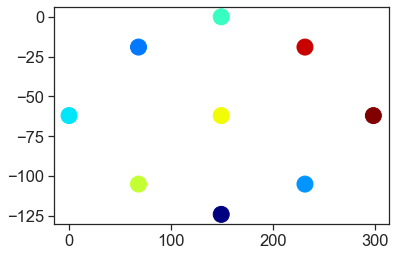

In [60]:
plt.scatter(poke_pos[:,0],poke_pos[:,1],s=256,c=act_matrix[:,2],cmap='jet')

In [61]:
act_matrix = np.array(act_matrix)

In [62]:
task1_corrs = np.corrcoef(act_matrix)

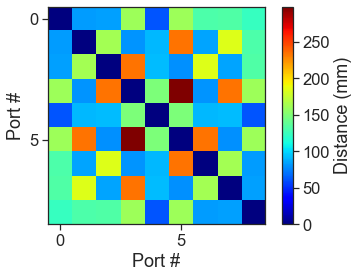

In [63]:
plt.imshow(-spatial_distance,cmap='jet')
plt.ylabel("Port #")
plt.xlabel("Port #")

cbar = plt.colorbar()
plt.locator_params(nbins=2)
cbar.set_label("Distance (mm)")


In [ ]:
cbar.

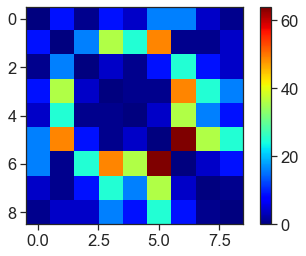

In [51]:
plt.imshow(-task_1_distance,cmap='jet')
plt.colorbar()

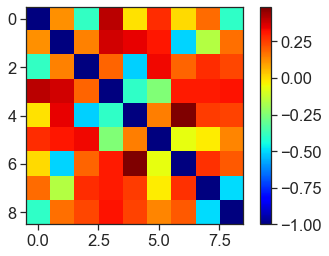

In [53]:
plt.imshow(-task1_corrs,cmap='jet')
plt.colorbar()

In [1466]:
spatial_distance = -distance_matrix(poke_pos,poke_pos,p=2)
if graph_type0=='loop': 
    task_1_distance = -loop_distance_matrix(seq0,p=1)
else: 
    task_1_distance =  -line_distance_matrix(seq0,p=1)#-(distance_matrix(seq0.reshape(-1,1),seq0.reshape(-1,1),p=1))
if graph_type1=='loop':
    task_2_distance = -loop_distance_matrix(seq1,p=1)
else:
    task_2_distance = -line_distance_matrix(seq1,p=1)

In [1467]:
X[:,2]

array([ 1.38842027,  0.91982843, -0.01735525, -0.48594709, -1.42313078,
        0.45123659, -0.95453893,  0.45123659,  0.91982843,  0.91982843,
        1.38842027, -0.48594709, -0.95453893, -1.89172262,  0.91982843,
       -1.42313078, -0.01735525,  0.45123659, -0.01735525, -0.48594709,
        1.38842027,  0.91982843, -0.01735525, -0.95453893,  0.45123659,
        0.91982843,  0.45123659, -0.48594709, -0.95453893,  0.91982843,
        1.38842027,  0.45123659, -1.42313078,  0.91982843,  0.45123659,
       -0.01735525, -1.42313078, -1.89172262, -0.01735525,  0.45123659,
        1.38842027, -2.36031446,  0.91982843, -0.48594709, -0.95453893,
        0.45123659,  0.91982843, -0.95453893, -1.42313078, -2.36031446,
        1.38842027, -1.89172262, -0.48594709, -0.01735525, -0.95453893,
       -1.42313078,  0.45123659,  0.91982843,  0.91982843, -1.89172262,
        1.38842027, -0.01735525, -0.48594709,  0.45123659, -0.01735525,
        0.91982843,  0.45123659, -0.48594709, -0.48594709, -0.01

In [1468]:
y = task1_corrs.flatten()
X = np.vstack([np.ones_like(y),
               zscore(spatial_distance).flatten(),
               zscore(task_1_distance).flatten(),
               zscore(task_2_distance).flatten()
              ]).T
res = sm.OLS(y,X,hasconst=True).fit()

In [1469]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     60.51
Date:                Sun, 14 Nov 2021   Prob (F-statistic):           3.34e-20
Time:                        21:38:49   Log-Likelihood:                 1.0809
No. Observations:                  81   AIC:                             5.838
Df Residuals:                      77   BIC:                             15.42
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0378      0.027      1.388      0.169      -0.016       0.092
x1             0.1229      0.030      4.112      0.000       0.063       0.182
x2             0.2351      0.032      7.429      0.000       0.172       0.298
x3             0.1054      0.032      3.330      0.001       0.042       0.168
==============================================================================
Omnibus:                        0.441   Durbin-Watson:                   1.716
Prob(Omnibus):                  0.802   Jarque-Bera (JB):                0.116
Skew:                           0.059   Prob(JB):                        0.944
Kurtosis:                       3.142   Cond. No.                         1.84
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Simulate the complex one